In [1]:
import pandas as pd
import numpy as np
import sqlite3 as lite
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import xgboost as xgb
from keras.layers import LSTM, Dense
from keras.models import Sequential

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#!pip install pmdarima
import pmdarima as pm

from google.colab import drive
#file = "/content/drive"
#drive.mount(file)

### Reading the db file with sqlite3

In [2]:
#loc= "/content/drive/MyDrive/fressnapf_case_study/fressnapf.db"
loc = "/content/fressnapf.db"
conn = lite.connect(loc)
cur = conn.cursor()

### To merge the tables

In [3]:
# Customer_ID is used as the primary key and customers and purchase tables are
# joined using left join to find any missing entry
# Product_ID is used as the secondary key to left join purchase on product table
# The data in the table is ordered according to timeline of earliest first

cur.execute("""

    CREATE TABLE IF NOT EXISTS FressnapfDataMergedTable(
      unique_key INTEGER PRIMARY KEY AUTOINCREMENT,
      Customer_ID INTEGER,
      Age INTEGER,
      Sex TEXT,
      Purchase_Date TIMESTAMP,
      Purchase_Channel TEXT,
      Product_ID INTEGER,
      Quantity INTEGER,
      Unit_Cost INTEGER,
      Category_type TEXT,
      Animal TEXT,
      Transaction_Counter INTEGER) """)

cur.execute("""
    INSERT INTO FressnapfDataMergedTable (
        Customer_ID, Age, Sex, Purchase_Date, Purchase_Channel,
        Product_ID, Quantity, Unit_Cost, Category_type, Animal
    )
    SELECT Customers.Customer_ID, Customers.Age, Customers.Sex,
           Purchase.Purchase_Date, Purchase.Purchase_Channel,
           Purchase.Product_ID, Purchase.Quantity,
           Products.Unit_Cost, Products.Category_type, Products.Animal
    FROM Customers
    LEFT JOIN Purchase ON Customers.Customer_ID = Purchase.Customer_ID
    LEFT JOIN Products ON Purchase.Product_ID = Products.Product_ID
    Order By Purchase.Purchase_Date
""")



### To create a Transaction update fressnapf table based on the Customer ID

### Not Able to execute the update effeciently


1.   High computational cost of update with the present approach
2.   Implemented the same with pandas in the next stage in a computaion efficient way



In [4]:
def transaction(cur):

    try:
      cur.execute("""
      ALTER TABLE FressnapfDataMergedTable
      ADD transaction_counter int
      """)

    except:
      print("Data exists in the table")

    cur.execute("""
                UPDATE FressnapfDataMergedTable
                SET transaction_counter = (
                  SELECT COUNT(*) FROM FressnapfDataMergedTable AS number_count
                  WHERE number_count.Customer_ID = FressnapfDataMergedTable.Customer_ID
                  AND number_count.Purchase_Date <= FressnapfDataMergedTable.Purchase_Date)
                LIMIT 100
    """)


    fressnapf_data = cur.execute("SELECT * FROM FressnapfDataMergedTable").fetchall()
    return fressnapf_data

update = True

if update:
    fressnapf_data = transaction(cur)

conn.commit()
conn.close()

Data exists in the table


### Unique key check and To convert into pandas DataFrame



In [5]:
# Customer_ID or time stamp is used as the unique key for the fressnapf_data table
ref_columns = ["unique_Key", "Customer_ID", "Age", "Sex", "Purchase_Date",
               "Purchase_Channel", "Product_ID", "Quantity", "Unit_Cost",
               "Category_type", "Animal", "Transaction_Counter"]

fressnapf_data_frame = pd.DataFrame(fressnapf_data, columns = ref_columns)

fressnapf_data_frame.head(50)

,unique_Key,Customer_ID,Age,Sex,Purchase_Date,Purchase_Channel,Product_ID,Quantity,Unit_Cost,Category_type,Animal,Transaction_Counter
0,1,1826040589,44,Female,2019-01-01 00:00:00,Store,1624,2,18.76,food,cats,7.0
1,2,1062241788,39,Female,2019-01-01 00:00:00,Store,4201,4,39.38,food,dogs,7.0
2,3,648880905,52,Male,2019-01-01 00:00:00,Store,4141,2,37.98,litter,cats,7.0
3,4,168983642,57,Female,2019-01-01 00:00:00,Store,1680,2,33.32,pharma,dogs,7.0
4,5,911705234,38,Female,2019-01-01 00:00:00,Store,3198,2,23.15,toys,cats,7.0
5,6,1765400555,56,Female,2019-01-01 00:00:00,Store,5044,1,25.36,food,dogs,7.0
6,7,1387097517,24,Female,2019-01-01 00:00:00,Online,2492,3,18.24,pharma,dogs,7.0
7,8,1267825056,48,Male,2019-01-01 00:00:00,Store,631,3,16.96,toys,cats,7.0
8,9,1861967394,63,Female,2019-01-01 00:00:00,Store,3366,3,19.32,toys,others,7.0
9,10,1987069828,65,Male,2019-01-01 00:00:00,Online,1416,3,21.04,litter,birds,7.0


### Strategy to Auto update the table using triggers



*   Triggers can be implemented to track the changes to the data base
*   When the trigger is activated, updates are to be made to the columns





#***Task 2 Business Insights***

# Profitablity (as a product of quantity and its cost)

## Need to include the cost of the product to find the actual value

In [6]:
# Count of unique products
fressnapf_data_frame["Product_ID"].nunique()

fressnapf_data_frame["sales_cost"] =  fressnapf_data_frame["Quantity"] * fressnapf_data_frame['Unit_Cost']
profit = fressnapf_data_frame.groupby("Product_ID")["sales_cost"].sum().reset_index()
profit = profit.sort_values("sales_cost", ascending=False).reset_index(drop=True)
profit

,Product_ID,sales_cost
0,3619,307352.50
1,3372,303535.40
2,4468,283393.74
3,3006,272039.18
4,4898,266566.16
...,...,...
4995,4293,17459.54
4996,4988,16198.07
4997,528,12250.00
4998,3367,7733.88


# Top 10 products in Profitablity

Top 10 sold products in terms of revenue 

   Product_ID  sales_cost
0        3619   307352.50
1        3372   303535.40
2        4468   283393.74
3        3006   272039.18
4        4898   266566.16
5        3175   265209.42
6        1973   264471.90
7        2512   259721.28
8        4226   255688.02
9        2968   254710.96


The product with highest profitability is
Product_ID: 3619, with profit: 307352.5



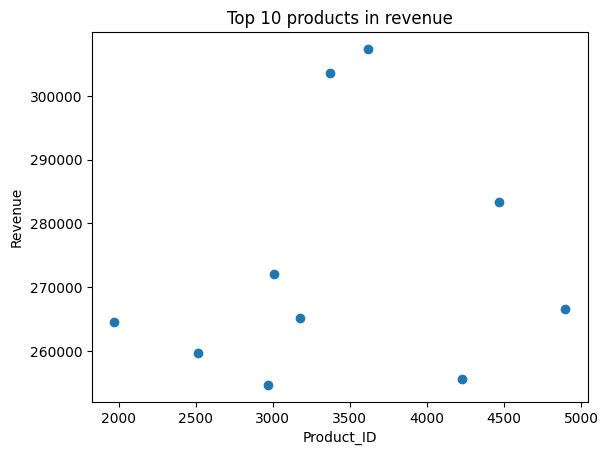

In [7]:
print('Top 10 sold products in terms of revenue \n')
print(profit.head(10))
print('\n')

print(f"""The product with highest profitability is
Product_ID: {profit['Product_ID'][0]}, with profit: {profit['sales_cost'][0]}\n""")

plt.scatter(profit['Product_ID'][:10], profit['sales_cost'][:10])
plt.xlabel('Product_ID')
plt.ylabel('Revenue')
plt.title('Top 10 products in revenue')
plt.show()

### Frequently Purchased Products

In [8]:
freq = fressnapf_data_frame.groupby("Product_ID")["Purchase_Date"].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['Product_ID', 'Frequency']
df_freq = df_freq.sort_values('Frequency', ascending=False).reset_index(drop=True)
print("Top 10 frequently purchased Products:\n")
df_freq

Top 10 frequently purchased Products:



,Product_ID,Frequency
0,1559,1918
1,4792,1862
2,2785,1862
3,3667,1855
4,3312,1855
...,...,...
4995,1913,1232
4996,825,1204
4997,3900,1183
4998,808,1162


# Top 10 products in Frequency of Purchase

Top 10 Frequently sold products

   Product_ID  Frequency
0        1559       1918
1        4792       1862
2        2785       1862
3        3667       1855
4        3312       1855
5        3380       1855
6        1544       1848
7        1219       1841
8         534       1834
9        3374       1834


The product with highest Frequency of sales is
Product_ID: 1559, with profit: 1918



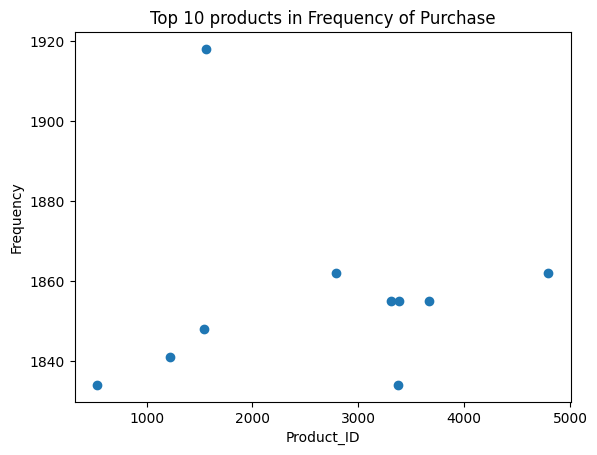

In [9]:
print('Top 10 Frequently sold products\n')
print(df_freq.head(10))
print('\n')

print(f"""The product with highest Frequency of sales is
Product_ID: {df_freq['Product_ID'][0]}, with profit: {df_freq['Frequency'][0]}\n""")

plt.scatter(df_freq['Product_ID'][:10], df_freq['Frequency'][:10])
plt.xlabel('Product_ID')
plt.ylabel('Frequency')
plt.title('Top 10 products in Frequency of Purchase')
plt.show()

In [10]:
# Count of unique customers
print("The number of unique customers are:",
      fressnapf_data_frame["Customer_ID"].nunique(), "\n")

#To avoid repeated count of pets, if the customer purchases for same pet
unique_customers = fressnapf_data_frame.drop_duplicates(subset=["Customer_ID", "Animal"])
customers = unique_customers["Animal"].value_counts()
df_customers = pd.DataFrame(customers).reset_index()
df_customers.columns = ['Animal', 'Count']
df_customers

The number of unique customers are: 99996 



,Animal,Count
0,dogs,98813
1,cats,96519
2,birds,80226
3,rodens,64581
4,others,40312


### The Most common Pet

### Pets distribution

The most common pet is
dogs with count: 98813



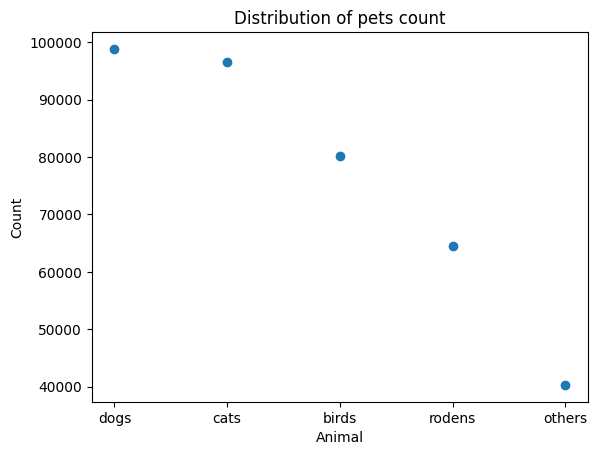

In [11]:
print(f"""The most common pet is
{df_customers['Animal'][0]} with count: {df_customers['Count'][0]}\n""")

plt.scatter(df_customers['Animal'], df_customers['Count'])
plt.xlabel('Animal')
plt.ylabel('Count')
plt.title('Distribution of pets count')
plt.show()

## Customer Segment Strategy

1.   List item
2.   List item




*   Behavioural Segmentation

      
     Recent, Frequency, and value of Purchase
     Frequency (onetime, regular, loyal),
     purchase value(low, medium, high),
     

---
*  Product Category Segmentation


    Type of Product (Food, Toys, medicine)

---

*   Demographic Segmentation


    Age and sex (adult, Middle Age, Old)








# Segment with More revenue is Behavioural Segmentation

---


*   High Revenue


    Loyal Customer with high purchase value
    Regular Customer with high purchase value



*   Medium Revenue


    Loyal Customer with medium purchase value
    Regular Customer with medium purchase value











# Revenue Estimation

# *Check customer or Product?*

In [12]:
# Categorize the frequency of Purchase and the profit of Purchase
market = df_freq.merge(profit, on='Product_ID')
market

,Product_ID,Frequency,sales_cost
0,1559,1918,157938.20
1,4792,1862,206915.52
2,2785,1862,108469.34
3,3667,1855,101580.57
4,3312,1855,138913.74
...,...,...,...
4995,1913,1232,58886.24
4996,825,1204,55712.79
4997,3900,1183,110848.50
4998,808,1162,100996.35


## Relation between the frequency and the profitability

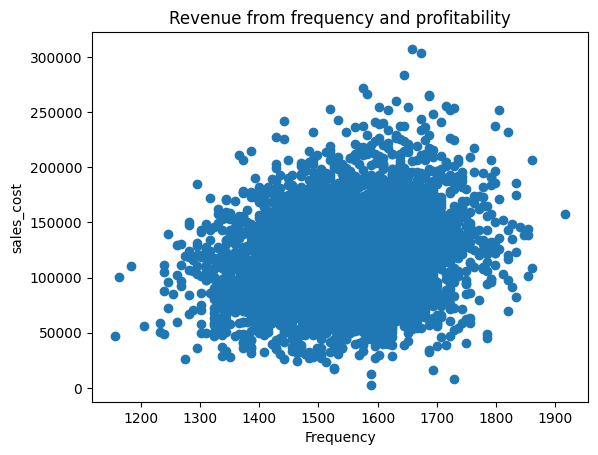

In [13]:
plt.scatter(market['Frequency'], market['sales_cost'])
plt.xlabel('Frequency')
plt.ylabel('sales_cost')
plt.title('Revenue from frequency and profitability')
plt.show()

### Define the category

    Recent
    ( Most Recent, Intermediate, Very Distant )
    ( From quartile3 to present, quartile1 to quartile3, upto quartile1 )  
    ( 2021, 2020, 2019)

    Frequent
    ( One-time customer, Regular customer, Loyal customer )
    ( Purchased 1 time, Purchased more than 1 time and less than quatrtile3, Purchased more than quatrtile3)

    value of purchase as the outcome to judge the segment outcome
    ( Low, Medium, High )
    ( first quartile, intermediate values, third quartile )

In [14]:
# Purchase Date
fressnapf_data_frame["Purchase_Date"] = pd.to_datetime(fressnapf_data_frame["Purchase_Date"], format="%Y-%m-%d %H:%M:%S")
purchase_date = fressnapf_data_frame["Purchase_Date"]

quatrtile1_date = np.percentile(purchase_date, 25)
quatrtile1_date = pd.to_datetime(quatrtile1_date)
quatrtile1_date = quatrtile1_date.strftime('%Y-%m-%d %H:%M:%S')
quatrtile1_date = pd.to_datetime(quatrtile1_date)

quatrtile3_date = np.percentile(purchase_date, 75)
quatrtile3_date = pd.to_datetime(quatrtile3_date)
quatrtile3_date = quatrtile3_date.strftime('%Y-%m-%d %H:%M:%S')
quatrtile3_date = pd.to_datetime(quatrtile3_date)

# Purchase Value
quatrtile1_value = np.percentile(fressnapf_data_frame["sales_cost"], 25)
quatrtile3_value = np.percentile(fressnapf_data_frame["sales_cost"], 50)


In [15]:
# Create a new column 'transaction_counter' and initialize it with 1
fressnapf_data_frame['transaction_counter'] = 1

# Use groupby and cumcount to calculate the transaction count for each customer
fressnapf_data_frame['transaction_counter'] += fressnapf_data_frame.groupby('Customer_ID').cumcount()

fressnapf_data_frame

,unique_Key,Customer_ID,Age,Sex,Purchase_Date,Purchase_Channel,Product_ID,Quantity,Unit_Cost,Category_type,Animal,Transaction_Counter,sales_cost,transaction_counter
0,1,1826040589,44,Female,2019-01-01,Store,1624,2,18.76,food,cats,7.0,37.52,1
1,2,1062241788,39,Female,2019-01-01,Store,4201,4,39.38,food,dogs,7.0,157.52,1
2,3,648880905,52,Male,2019-01-01,Store,4141,2,37.98,litter,cats,7.0,75.96,1
3,4,168983642,57,Female,2019-01-01,Store,1680,2,33.32,pharma,dogs,7.0,66.64,1
4,5,911705234,38,Female,2019-01-01,Store,3198,2,23.15,toys,cats,7.0,46.30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7685981,7685982,1527272795,42,Male,2021-01-01,Store,4686,5,26.65,litter,dogs,NaN,133.25,84
7685982,7685983,1028061482,27,Female,2021-01-01,Store,4456,3,39.06,toys,dogs,NaN,117.18,91
7685983,7685984,1505968287,45,Male,2021-01-01,Store,2926,4,25.67,litter,rodens,NaN,102.68,42
7685984,7685985,1579528283,54,Male,2021-01-01,Online,3290,2,39.71,food,dogs,NaN,79.42,70


In [16]:
print(fressnapf_data_frame['transaction_counter'].describe())


count    7.685986e+06
mean     4.245138e+01
std      2.765065e+01
min      1.000000e+00
25%      2.000000e+01
50%      3.900000e+01
75%      6.100000e+01
max      1.960000e+02
Name: transaction_counter, dtype: float64


In [17]:
def age_category(data, limit1, limit2, least_value):
  if least_value <= data < limit1:
    return "Young Adult"
  elif limit1 <= data < limit2:
    return "Middle Aged"
  elif data >= limit2:
    return "Seniors"
  else:
    print(data)
    return None

least_value = 17
limit1 = 30
limit2 = 50

print(f"""Young Adult: {least_value} to {limit1},
Middle Aged: {limit1} to {limit2},
Seniors: Above {limit2}\n""")

fressnapf_data_frame["Person_age"] = fressnapf_data_frame["Age"].apply(
    lambda x: age_category(x, limit1, limit2, least_value))


def transaction_frequency(data, limit1, limit2):
  if data < limit1:
    return "Least"
  elif limit1 <= data < limit2:
    return "Average"
  elif data >= limit2:
    return "High"
  else:
    print(data)
    return None

limit1 = np.percentile(fressnapf_data_frame["transaction_counter"], 25)
limit2 = np.percentile(fressnapf_data_frame["transaction_counter"], 75)

print(f"""Least frequency: upto {limit1},
Average frequency: {limit1} to {limit2},
High frequency: Above {limit2}\n""")

fressnapf_data_frame["transation_frequency"] = fressnapf_data_frame["transaction_counter"].apply(
    lambda x: transaction_frequency(x, limit1, limit2))


def value_category(data, least_value, quatrtile1_value, quatrtile3_value):
  if (data >= least_value) and (data < quatrtile1_value):
    return "Low valued Purchase"
  elif (data >= quatrtile1_value) and (data < quatrtile3_value):
    return "Medium valued Purchase"
  elif (data >= quatrtile3_value):
    return"High valued Purchase"
  else:
    return None


least_value = 0
highest_value = fressnapf_data_frame["sales_cost"].max()

print(f"""Low Purchase: {least_value} to {quatrtile1_value},
Medium Purchase: {quatrtile1_value} to {quatrtile3_value},
High Purchase: Above {quatrtile3_value}; Max Purchase made till now {highest_value}\n""")

fressnapf_data_frame["value"] = fressnapf_data_frame["sales_cost"].apply(
    lambda x: value_category(x, least_value, quatrtile1_value, quatrtile3_value))




# Not clear on the use strategy

def recency_category(date, first_date, quatrtile1_date, quatrtile3_date):
  if (date >= first_date) and (date < quatrtile1_date):
    return "Very Distant Purchase"
  elif (date >= quatrtile1_date) and (date < quatrtile3_date):
    return "Intermediate Purchase"
  elif (date >= quatrtile3_date):
    return"Recent Purchase"
  else:
    return None

first_date = purchase_date[0]
last_date = purchase_date.iloc[-1]

print(f"""Very Distant Purchase: {first_date} to {quatrtile1_date},
Intermediate Purchase: {quatrtile1_date} to {quatrtile3_date},
Recent Purchase: {quatrtile3_date} to {last_date}\n\n""")

recent = fressnapf_data_frame["Purchase_Date"].apply(
    lambda x: recency_category(x, first_date,
                               quatrtile1_date,
                               quatrtile3_date))


Young Adult: 17 to 30,
Middle Aged: 30 to 50,
Seniors: Above 50

Least frequency: upto 20.0,
Average frequency: 20.0 to 61.0,
High frequency: Above 61.0

Low Purchase: 0 to 53.12,
Medium Purchase: 53.12 to 72.30000000000001,
High Purchase: Above 72.30000000000001; Max Purchase made till now 405.29999999999995

Very Distant Purchase: 2019-01-01 00:00:00 to 2019-07-05 00:00:00,
Intermediate Purchase: 2019-07-05 00:00:00 to 2020-07-03 00:00:00,
Recent Purchase: 2020-07-03 00:00:00 to 2021-01-01 00:00:00




In [18]:
fressnapf_data_frame

#new = pd.DataFrame(fressnapf_data_frame.groupby("Customer_ID"))
#new.columns = ["Customer_ID", "Purchase_Date"]

,unique_Key,Customer_ID,Age,Sex,Purchase_Date,Purchase_Channel,Product_ID,Quantity,Unit_Cost,Category_type,Animal,Transaction_Counter,sales_cost,transaction_counter,Person_age,transation_frequency,value
0,1,1826040589,44,Female,2019-01-01,Store,1624,2,18.76,food,cats,7.0,37.52,1,Middle Aged,Least,Low valued Purchase
1,2,1062241788,39,Female,2019-01-01,Store,4201,4,39.38,food,dogs,7.0,157.52,1,Middle Aged,Least,High valued Purchase
2,3,648880905,52,Male,2019-01-01,Store,4141,2,37.98,litter,cats,7.0,75.96,1,Seniors,Least,High valued Purchase
3,4,168983642,57,Female,2019-01-01,Store,1680,2,33.32,pharma,dogs,7.0,66.64,1,Seniors,Least,Medium valued Purchase
4,5,911705234,38,Female,2019-01-01,Store,3198,2,23.15,toys,cats,7.0,46.30,1,Middle Aged,Least,Low valued Purchase
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7685981,7685982,1527272795,42,Male,2021-01-01,Store,4686,5,26.65,litter,dogs,NaN,133.25,84,Middle Aged,High,High valued Purchase
7685982,7685983,1028061482,27,Female,2021-01-01,Store,4456,3,39.06,toys,dogs,NaN,117.18,91,Young Adult,High,High valued Purchase
7685983,7685984,1505968287,45,Male,2021-01-01,Store,2926,4,25.67,litter,rodens,NaN,102.68,42,Middle Aged,Average,High valued Purchase
7685984,7685985,1579528283,54,Male,2021-01-01,Online,3290,2,39.71,food,dogs,NaN,79.42,70,Seniors,High,High valued Purchase


The transaction category relation to sales
   transation_frequency    sales_cost
0              Average  2.928543e+08
1                 High  1.526739e+08
2                Least  1.462418e+08


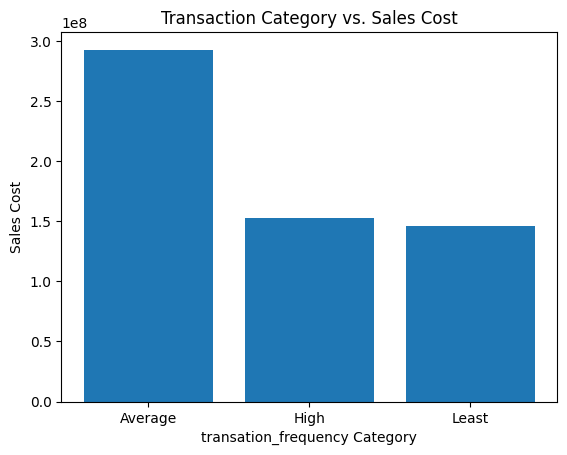


The value category relation to sales
                     value    sales_cost
0    High valued Purchase  3.948632e+08
1     Low valued Purchase  7.655238e+07
2  Medium valued Purchase  1.203544e+08


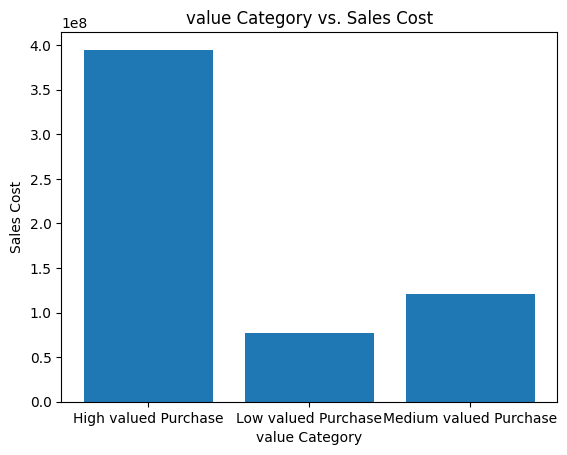


The person age category relation to sales
     Person_age    sales_cost
0  Middle Aged  3.652125e+08
1      Seniors  1.868110e+08
2  Young Adult  3.974643e+07


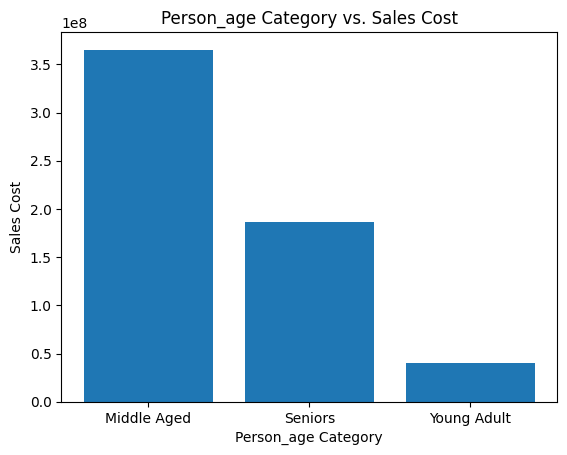

In [19]:
# Define the relation between the pattern of "transation_frequency", "value", "Person_age" to sales_cost

data_transation_frequency = fressnapf_data_frame.groupby("transation_frequency")["sales_cost"].sum().reset_index()
print("The transaction category relation to sales\n", data_transation_frequency)
plt.bar(data_transation_frequency["transation_frequency"], data_transation_frequency["sales_cost"])
plt.xlabel("transation_frequency Category")
plt.ylabel("Sales Cost")
plt.title("Transaction Category vs. Sales Cost")
plt.show()

data_transation_frequency = fressnapf_data_frame.groupby("value")["sales_cost"].sum().reset_index()
print("\nThe value category relation to sales\n", data_transation_frequency)
plt.bar(data_transation_frequency["value"], data_transation_frequency["sales_cost"])
plt.xlabel("value Category")
plt.ylabel("Sales Cost")
plt.title("value Category vs. Sales Cost")
plt.show()

data_transation_frequency = fressnapf_data_frame.groupby("Person_age")["sales_cost"].sum().reset_index()
print("\nThe person age category relation to sales\n", data_transation_frequency)
plt.bar(data_transation_frequency["Person_age"], data_transation_frequency["sales_cost"])
plt.xlabel("Person_age Category")
plt.ylabel("Sales Cost")
plt.title("Person_age Category vs. Sales Cost")
plt.show()


## Churn is the reduction in the count of customers after a period of time

- My choice is diving the year into 4 quartiles and find the churn

1.   Churn can be found monthly or quaterly or yearly




In [ ]:
# Set first_date to the first date in your dataset
first_date = pd.Timestamp("2019-01-01")

# Define the churn_category function
def churn_category(data, start, jump):
    year = start.year
    month = start.month
    part_of_year = 1
    limit = pd.Timestamp("2019-04-01")

    while start < pd.Timestamp("2021-12-31"):
        if start <= data < limit:
            return f"{year}-{part_of_year}half"
        else:
            month += jump
            part_of_year += 1

            if month > 12:
                year += 1
                month = 1
                part_of_year = 1

            # Ensure month_limit doesn't exceed 12
            month_limit = month + jump if month + jump <= 12 else 12

            start = limit
            limit = pd.Timestamp(f"{year}-{month_limit:02d}-01")

fressnapf_data_frame["Quarterly_Group"] = fressnapf_data_frame["Purchase_Date"].apply(
    lambda x: churn_category(x, first_date, jump=3))



In [ ]:
# The customers who are purchasing again in the period of 3 months are also considered
quaterly_churn = fressnapf_data_frame.groupby("Quarterly_Group")["Customer_ID"].count()

# As the 2021 1 half has only data from 1 month, it is excluded in the quaterly calculation of churn
churn_data = []
for i in range(len(quaterly_churn)-2):
    churn_rate = (quaterly_churn[i] - quaterly_churn[i+1]) / quaterly_churn[i]
    churn_data.append(churn_rate)

print("The churn rate for quartiles of 3 months is: \n", churn_data, "\n")

print("A Trend of decreasing customer count is seen in the fourth quartile of the year")


# Task 3 - Customer Segmentation using kMeans clustring

In [ ]:
# Creating a copy of the data file before data Pre-processing for kmeans clusting
old_data = fressnapf_data_frame

In [ ]:
# Extracting year, month, and date from the Purchase_Date to use as features
fressnapf_data_frame["year"] = fressnapf_data_frame["Purchase_Date"].dt.year
fressnapf_data_frame["month"] = fressnapf_data_frame["Purchase_Date"].dt.month

fressnapf_data_frame

In [ ]:
# Removing Unwanted Columns
fressnapf_data_frame = fressnapf_data_frame.drop(["Purchase_Date", "Transaction_Counter", "Customer_ID", "unique_Key", "Quantity", "Unit_Cost", "Age"], axis=1)

In [ ]:
# Columns to encode
columns_to_encode = ['Sex', 'Purchase_Channel', 'Category_type', 'Animal',
                     'value', 'Quarterly_Group', 'Person_age',
                     'transation_frequency']

# Perform label encoding
# To collect the encoding fit and use further to decode the values
encoding_fit = {}

for encoding in columns_to_encode:
    le = LabelEncoder()
    fressnapf_data_frame[encoding] = le.fit_transform(fressnapf_data_frame[encoding])

    # Store the encoding fit in the dictionary
    encoding_fit[encoding] = le


In [ ]:
# Perform scaling of the numerical data and dates

def scale(data, label):
    scale_param = StandardScaler().fit(data.values.reshape(-1, 1))
    data = scale_param.transform(data.values.reshape(-1, 1))
    return data, scale_param

labels_to_scale = ["year", "month", "Product_ID",
                   "transaction_counter", "sales_cost"]


# To collect the scaling fit and use further to unscale the values
scaling_fit = {}
# Scaling the labels
for label in labels_to_scale:
    fressnapf_data_frame[label], scale_param = scale(fressnapf_data_frame[label], label)
    scaling_fit[label] = scale_param



In [ ]:
df_encoded = fressnapf_data_frame
df_encoded

In [ ]:
elbow_points = []

for cluster in range(2,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++', n_init='auto')
    kmeans.fit(df_encoded)
    elbow_points.append(kmeans.inertia_)
    print("\nCluster No:", cluster)
    print("Intertia Score", kmeans.inertia_)
    print("davies_bouldin_score", davies_bouldin_score(df_encoded, kmeans.labels_))
    print("calinski_harabasz_score", calinski_harabasz_score(df_encoded, kmeans.labels_))
    print("\n")

In [ ]:
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(2,10), 'elbow_points':elbow_points})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['elbow_points'], marker='*')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Elbow points and the scores show 5 or 6 or 7 clusters a reasonable choice for selection

1.  In the present work, 5 clusters were choosen because of the trade-off




In [ ]:
k_means = KMeans(n_clusters=5, init='k-means++', n_init='auto')
k_means.fit(df_encoded)

# Evaluation of the clustring

In [ ]:
df_encoded["Cluster"] = k_means.predict(df_encoded)
df_encoded

In [ ]:
data = df_encoded.corr()

In [ ]:
# Create a heatmap
plt.figure(figsize=(24, 16))
sns.heatmap(data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# CLUSTER RELATION WITH PARAMETERS (Person_age, transation_frequency, value, Quarterly_Group)

# Define the parameters for the heatmap
parameters = ["Person_age", "transation_frequency", "value", "Quarterly_Group"]

# Calculate the correlation matrix
correlation_matrix = df_encoded[parameters + ["Cluster"]].corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Cluster-Parameter Correlation Heatmap")
plt.show()


In [ ]:

label = [["Young Adult, Middle Aged, Seniors"],
        ["Least frequency, Average frequency, High frequency"],
        ["Low Purchase,Medium Purchase, High Purchase"],
        ["""2019-1half, 2019-2half, 2019-3half, 2019-4half, 2020-1half, 2020-2half, 2020-3half, 2020-4half, 2021-1half"""]]

fressnapf_data_frame["value"] = fressnapf_data_frame["sales_cost"].apply(
    lambda x: value_category(x, least_value, quatrtile1_value, quatrtile3_value))

# CLUSTER RELATION WITH PARAMETERS (Person_age, transation_frequency, value, Quarterly_Group)
parameters = ["Person_age", "transation_frequency", "value", "Quarterly_Group"]


# Iterate through the parameters
for parameter, label in zip(parameters, label):

    # Create a clustered bar chart to visualize the distribution of age in clusters
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_encoded, x="Cluster", hue=parameter)

    print("The Labels are:\n", label)
    # Customize plot labels and legend
    plt.xlabel("Cluster")
    plt.ylabel(parameter)
    plt.title(f"Distribution of {parameter} in Clusters")
    plt.legend(title=parameter)
    plt.show()
    print("\n")

# Forecasting

In [ ]:
data_forecast = old_data[["Purchase_Date", "sales_cost"]]

plt.hist(data_forecast['sales_cost'], bins=50, edgecolor='k')
plt.title('Sales Cost Distribution')
plt.xlabel('Sales Cost')
plt.ylabel('Frequency')
plt.show()

data_forecast = data_forecast.groupby("Purchase_Date")["sales_cost"].sum().reset_index()

data_forecast["year"] = data_forecast["Purchase_Date"].dt.year
data_forecast["month"] = data_forecast["Purchase_Date"].dt.month
data_forecast["day"] = data_forecast["Purchase_Date"].dt.day

# Forecast on day basis is highly fluctuating
# The choice of monthly forecast shows trends and seasonality
data_forecast = data_forecast.groupby(["year", "month"])["sales_cost"].sum().reset_index()
data_forecast["date"] = data_forecast["year"].astype(str) + ' - ' + data_forecast["month"].astype(str)

# As the data for the last month i.e jan of 2021 is not complete, and
# the forecast is made on months, last month is skipped

data_forecast = data_forecast[:-1]
data_forecast

In [ ]:
# Plot to check the data patterns

def pattern_plot(param1, param2, param):
    plt.figure(figsize=(10, 6))
    plt.plot(param1, param2)
    plt.legend(["Sales_Cost"])
    plt.title(f"Sales Value forecast for {param}")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# month plot
pattern_plot(data_forecast["date"], data_forecast["sales_cost"], "month")
print("\n")

# day plot
pattern_plot(old_data["Purchase_Date"], old_data["sales_cost"], "days")
print("\n")

# year plot
year_data = data_forecast.groupby("year")["sales_cost"].sum().reset_index()
year_data
# pattern_plot(year_data["year"], year_data["sales_cost"], "years")


Monthly trend


    Drop of sales: Feb, June,  September, December
    Raise of sales: March - April - May, July - Aug, Oct


Year trend

    There has been a decrease in the customer spending in total in year 2020 than year 2021

In [ ]:
data = data_forecast["sales_cost"].values.reshape(-1, 1)

# 90 percent of the data for training and 10 percen to test
split_limit = int(len(data_forecast["year"]) * 0.90)

scaling_value = StandardScaler().fit(data[:split_limit])

train_data = data_forecast[["year", "month"]]


x_train, y_train, x_test, y_test = (train_data[:split_limit],
                                    scaling_value.fit_transform(data[:split_limit]),
                                    train_data[split_limit:],
                                    scaling_value.transform(data[split_limit:]))


# Providing a Choice between XGboost, Lstm and Arima

In [ ]:
options = ("XGBoost", "Lstm", "Arima")

manual_entry = False
choice = "Lstm"

while manual_entry:
  choice = input("Enter a choice between XGBoost or Lstm: ")
  print(f"You have opted for {choice}")
  if choice not in options:
    print("Please check the option choosen \n")
    continue
  else:
    print(f"Executing {choice}\n")
    break
print("Going for model training")

In [ ]:
class XGBoost:

    def __init__(self, x_train, y_train, x_test, y_test):
      self.x_train = x_train
      self.x_test = x_test
      self.y_train = y_train
      self.y_test = y_test

    def train_model(self):
      model = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds=100, learning_rate=1)
      model.fit(self.x_train, self.y_train, eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)], verbose=50)

      importance = pd.DataFrame(data= model.feature_importances_, index = model.feature_names_in_, columns=["importance"])
      importance.sort_values("importance").plot(kind="barh", title="Importance of the Features")
      plt.show()
      y_pred = model.predict(self.x_test)
      return y_pred

class Lstm:

  def __init__(self, x_train, y_train, x_test, y_test):
    self.test = x_test
    self.x_train = np.expand_dims(x_train, axis=-1)
    self.x_test = np.expand_dims(x_test, axis=-1)
    self.y_train = y_train
    self.y_test = y_test

  def train_model(self):
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (self.x_train.shape[1], 1)))
    regressor.add(LSTM(units = 50))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    regressor.fit(self.x_train, self.y_train, batch_size=4, epochs=1000)
    return regressor.predict(self.x_test)


class Arima:

  def __init__(self, x_train, y_train, x_test, y_test):
    self.x_train = x_train
    self.x_test = x_test
    self.y_train = y_train
    self.y_test = y_test

  def train_model(self):
    # Seasonality
    seasonality = seasonal_decompose(self.y_train, period=3)
    rcParams['figure.figsize'] = (10, 8)
    fig = seasonality.plot()
    plt.show()
    print("\n")

    # Correlation
    plot_acf(y_train, lags=3)
    plt.show()
    print("\n")

    plot_pacf(y_train, lags=3)
    plt.show()
    print("\n")

    # auto arima
    #model= pm.auto_arima(["PJME_MW"], min_p=1, max_p=3, start_q=0, max_q=1, trace=True, njpbs=-1, maxiters=5)
    #return pd.DataFrame(model.predict(n_periods=len(test["PJME_MW"])))


In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# Statistical Model

In [ ]:

#mapping = {'XGBoost' : XGBoost, 'Lstm' : Lstm, 'Arima': Arima}
#process = mapping[choice](x_train, y_train, x_test, y_test)

process = Arima(x_train, y_train, x_test, y_test)
y_test_pred = process.train_model()
print("\n")

# LSTM Model

In [ ]:
process = Lstm(x_train, y_train, x_test, y_test)
y_test_pred = process.train_model()
print("\n")

In [ ]:
# Months data over a larger data sample can be useful in future for better prediction

def plot(y_test_pred, x_test, y_test, choice, x_train, y_train):

  plt.plot(x_train, y_train)
  plt.plot(x_test, y_test)
  plt.plot(x_test, y_test_pred)
  plt.legend(["y_train", "y_test", "y_pred"])
  plt.title(f"Sales Value forecast From {choice}")
  plt.show()

plot(y_test_pred, data_forecast["date"][split_limit:],
     y_test, choice, data_forecast["date"][:split_limit], y_train)

pred = (np.array(y_test_pred)).reshape(-1, 1)

In [ ]:

# Convert to inverse transforms and compare
error = mape(np.array(y_test).reshape(-1, 1), pred)

print(f"Executed: {choice}")
print(f'Error in the prediction: {error}')

# Task 4 - Cat Litter Sale

In [ ]:
cat_customers = old_data.where(old_data["Animal"] == "cats").groupby("Animal")


In [ ]:
# CATS RELATION WITH PARAMETERS
parameters = ["Age", "Sex", "Quantity", "Purchase_Channel", "sales_cost"]

cat_dataframe = pd.DataFrame()

for parameter in parameters:
    cat_dataframe[parameter] = cat_customers[parameter].apply(lambda x: x.reset_index(drop=True)).reset_index(drop=True)

cat_dataframe

In [ ]:
cat_dataframe.groupby("Sex")["sales_cost"].sum()
# Females spend almost double the money than men who has a cat
# Advertisements and offers can be targeted to attract more towards female customers


In [ ]:
cat_dataframe.groupby("Age")["sales_cost"].sum()
# Customers of age 32 to 56 spend more money
# Advertisements and offers can be targeted to attract more loyal customers of age 32 to 56 with newsletters and loyality points

In [ ]:
cat_dataframe.groupby("Purchase_Channel")["sales_cost"].sum()
# Major customers purchase happens at stores.
# Promoting online sales in younger customer category and advertisements for in store purchase customers

In [ ]:
cat_dataframe.groupby("Quantity")["sales_cost"].sum()
# Major customers purchase quantity is around 2 to 4 items
# Promotional or upgrade offer of less cost product can attract more sales - upselling